Error loading image: type object 'Image' has no attribute 'open'


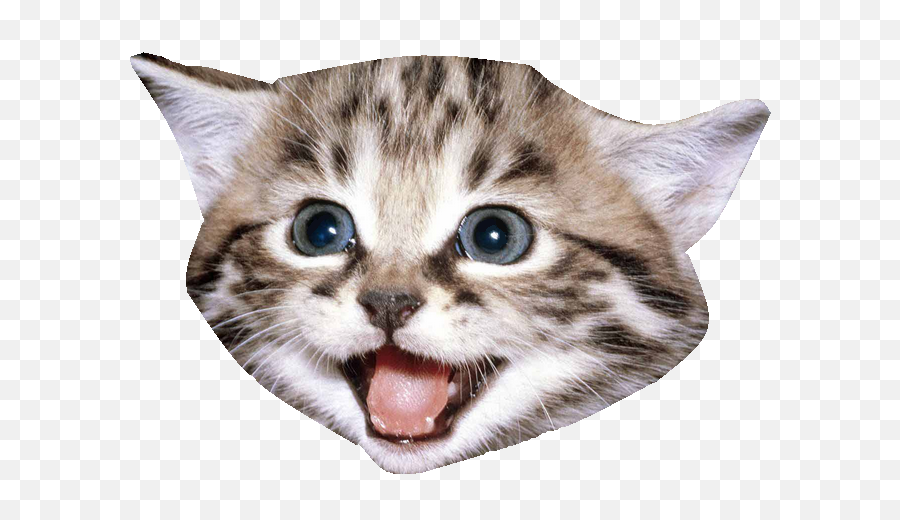

In [4]:
from PIL import Image
from IPython.display import Image, display
import os

image_path = './artifacts/provider/test_image.png'
try:
    img = Image.open(image_path)
    print(f"Image loaded successfully from {image_path}")
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
except Exception as e:
    print(f"Error loading image: {e}")
display(Image(filename=image_path))

In [5]:
from openai import OpenAI
import sys
import time
model = "gemma3:12b-it-q8_0"
def create_client():
    """Create and return an OpenAI client configured for Ollama."""
    return OpenAI(
        base_url='http://localhost:11434/v1',
        api_key='ollama'  # required but unused
    )

def test_basic_chat(client):
    """Test a basic chat completion."""
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": "What is the capital of France?"}
            ]
        )
        print("\n=== Basic Chat Test ===")
        print(f"Response: {response.choices[0].message.content}")
        return True
    except Exception as e:
        print(f"Error in basic chat test: {e}")
        return False

def test_multi_turn_conversation(client):
    """Test a multi-turn conversation."""
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": "What is Python?"},
                {"role": "assistant", "content": "Python is a high-level, interpreted programming language."},
                {"role": "user", "content": "What are its main features?"}
            ]
        )
        print("\n=== Multi-turn Conversation Test ===")
        print(f"Response: {response.choices[0].message.content}")
        return True
    except Exception as e:
        print(f"Error in multi-turn conversation test: {e}")
        return False

def test_code_generation(client):
    """Test code generation capabilities."""
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful coding assistant."},
                {"role": "user", "content": "Write a Python function to calculate the factorial of a number."}
            ]
        )
        print("\n=== Code Generation Test ===")
        print(f"Response: {response.choices[0].message.content}")
        return True
    except Exception as e:
        print(f"Error in code generation test: {e}")
        return False

def main():
    """Main function to run all tests."""
    print("Starting Ollama API tests...")
    
    try:
        client = create_client()
        
        # Run tests
        tests = [
            ("Basic Chat", test_basic_chat),
            ("Multi-turn Conversation", test_multi_turn_conversation),
            ("Code Generation", test_code_generation)
        ]
        
        results = []
        for test_name, test_func in tests:
            print(f"\nRunning {test_name}...")
            success = test_func(client)
            results.append((test_name, success))
            time.sleep(1)  # Add small delay between tests
        
        # Print summary
        print("\n=== Test Summary ===")
        for test_name, success in results:
            status = "✓ Passed" if success else "✗ Failed"
            print(f"{test_name}: {status}")
            
    except Exception as e:
        print(f"Error setting up client: {e}")
        sys.exit(1)

# if __name__ == "__main__":
#     main() 

In [6]:
def test_caption(client):
    """Test generating a simple image caption."""
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant that generates image captions."},
                {"role": "user", "content": f"Generate a brief caption for the image located at {image_path}. Describe it in a single sentence."}
            ]
        )
        print("\n=== Image Caption Test ===")
        caption = response.choices[0].message.content
        print(f"Caption: {caption}")
        return True
    except Exception as e:
        print(f"Error in image caption test: {e}")
        return False
    
test_caption(create_client())


=== Image Caption Test ===
Caption: The test_image.PNG shows a black and white photograph of a cat wearing a playful party wig laying on patterned sheets.


True

In [16]:
import base64
from openai import OpenAI
import openai
from pydantic import BaseModel
import json

# Initialize the client using the OpenAI compatibility layer.
client = OpenAI(base_url="http://localhost:11434/v1", api_key="ollama")

# Define the image path and original model.
image_path = './artifacts/provider/test_image.png'
model = "gemma3:12b-it-q8_0"

# Define the StructuredCaption schema.
class StructuredCaption(BaseModel):
    scratchpad: str
    caption: str

# Define the prompt for generating a structured caption.
prompt = (
    "Analyze the provided image and generate a structured caption. "
    "Include a brief scratchpad of your thought process and a final concise caption. "
    "Return as JSON with keys 'scratchpad' and 'caption'."
)

# Read and encode the image as base64.
with open(image_path, "rb") as image_file:
    b64_image = base64.b64encode(image_file.read()).decode("utf-8")

# Use the parsed API with the new input format.
try:
    completion = client.beta.chat.completions.parse(
        temperature=0,
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "input_text", "text": prompt},
                    {"type": "input_image", "image_url": f"data:image/png;base64,{b64_image}"},
                ]
            }
        ],
        response_format=StructuredCaption,
    )

    response_message = completion.choices[0].message
    if response_message.parsed:
        print("Parsed Structured Caption:")
        print("Scratchpad:", response_message.parsed.scratchpad)
        print("Caption:", response_message.parsed.caption)
    elif response_message.refusal:
        print("Refusal:", response_message.refusal)
except Exception as e:
    print("Error during parsed API call:", e)

Error during parsed API call: Error code: 400 - {'error': {'message': 'invalid message format', 'type': 'invalid_request_error', 'param': None, 'code': None}}
